In [1]:
import sys
sys.path.append('../')
from read_json import load_from_json
from parse_cedar_objects import parse_cedar_params
import nengo
import numpy as np
import matplotlib.pyplot as plt
from cedar_modules import AbsSigmoid

In [2]:
objects, connections = load_from_json('../JSON/test_architecture.json')

In [3]:
model = nengo.Network()

with model:
    nengo_objects = {}
    for ob_key in objects:
        print(ob_key)
        name, instance = parse_cedar_params(objects[ob_key])
        instance.make_node()
        nengo_objects[name] = instance

Flip
Gauss Input 2
Projection
Projection 2
Spatial Template
Group 1.Component Multiply
Group 1.Neural Field
Group 1.Static Gain
Group 2.Gauss Input
Group 2.Neural Field 2


In [4]:
nengo_objects

{'Flip': <cedar_modules.Flip at 0x7ff330174a58>,
 'Gauss Input 2': <cedar_modules.GaussInput at 0x7ff330174ac8>,
 'Projection': <cedar_modules.Projection at 0x7ff330174be0>,
 'Projection 2': <cedar_modules.Projection at 0x7ff330174c18>,
 'Spatial Template': <cedar_modules.SpatialTemplate at 0x7ff330174c88>,
 'Group 1.Component Multiply': <cedar_modules.ComponentMultiply at 0x7ff330174cf8>,
 'Group 1.Neural Field': <cedar_modules.NeuralField at 0x7ff330174dd8>,
 'Group 1.Static Gain': <cedar_modules.StaticGain at 0x7ff330174e48>,
 'Group 2.Gauss Input': <cedar_modules.GaussInput at 0x7ff330944240>,
 'Group 2.Neural Field 2': <cedar_modules.NeuralField at 0x7ff330174f28>}

In [5]:
def make_connection(source_name, target_name, object_dict):
    source = source_name.rsplit('.',1)[0]
    target = target_name.rsplit('.',1)[0]
    
    target_object = object_dict[target]
    # there are some special cases where the type of object
    # changes the connection that is made 
    # 1. special case: the target is a ComponentMultiply
    if target_object.__class__.__name__ == 'ComponentMultiply':
        if target_object.connections == 0:
            # connect to the first entries
            target_entries = target_object.node[:np.product(target_object.inp_size1)]
            target_object.connections += 1
        elif target_object.connections == 1:
            # connect to the last entries
            target_entries = target_object.node[np.product(target_object.inp_size1):]
            # count plus 1 again to realize when trying to add a third connection
            target_object.connections += 1
        else:
            print('Too many connections for ComponentMultiply!')
    # 2. special case: the target is a Convolution
    elif target_object.__class__.__name__ == 'Convolution':
        # the source can be the kernel or the matrix
        if target_name.rsplit('.',1)[1] == 'kernel':
            target_entries = target_object.node[:np.prod(target_object.sizes)]
        # if it's not the kernel, it's the matrix
        else:
            target_entries = target_object.node[:np.prod(target_object.sizes)]
    # otherwise the target entries are all entries of the target node
    else:
        target_entries = target_object.node
    # 3. special case: the source is a NeuralField --> need sigmoided activation
    if object_dict[source].__class__.__name__ == 'NeuralField':
        sigmoid = AbsSigmoid()
        nengo.Connection(object_dict[source].node, target_entries,
                         synapse=0, function=sigmoid)
        
    # just normal connection
    else:
        nengo.Connection(object_dict[source].node, target_entries,
                         synapse=0)
            
    

In [6]:
with model:
    for connection in connections:
        print(connection[0][1], connection[1][1])
        make_connection(connection[0][1], connection[1][1], nengo_objects)
    
    probes = {}
    for key in nengo_objects:
        probes[key] = nengo.Probe(nengo_objects[key].node)

Group 1.Static Gain.output Flip.input
Group 2.Neural Field 2.sigmoided activation Projection.input
Group 2.Neural Field 2.sigmoided activation Projection 2.input
Gauss Input 2.Gauss input Group 1.Component Multiply.operands
Spatial Template.spatial pattern Group 1.Component Multiply.operands
Spatial Template.spatial pattern Group 1.Static Gain.input
Group 1.Neural Field.sigmoided activation Group 2.Neural Field 2.input
Group 1.Component Multiply.product Group 1.Neural Field.input
Group 1.Static Gain.output Group 1.Neural Field.input
Group 2.Gauss Input.Gauss input Group 2.Neural Field 2.input


In [7]:
sim = nengo.Simulator(model)
with sim:
    sim.run(0.5)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

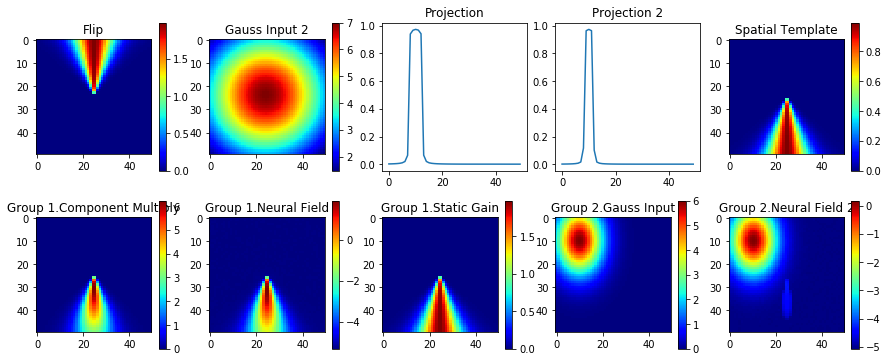

In [8]:
time_point = 200
plt.figure(figsize=(15,6))
for i, key in enumerate(probes):
    plt.subplot(2,5, i+1)
    probe_data = sim.data[probes[key]]
    if probe_data.shape[1] == 2500:
        plt.title(key)
        plt.imshow(probe_data[time_point,:].reshape(50,50), cmap='jet')
        plt.colorbar()
    else:
        plt.title(key)
        plt.plot(probe_data[time_point,:])
        
plt.show()
        

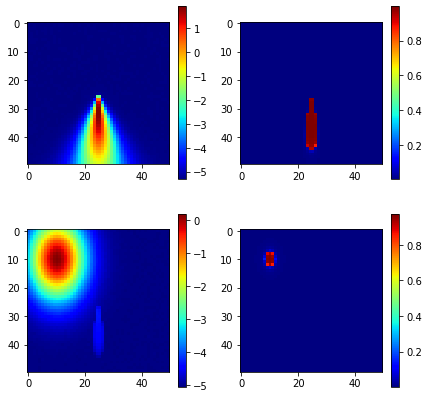

In [9]:
plt.figure(figsize=(7,7))
plt.subplot(2,2,1)
plt.imshow(sim.data[probes['Group 1.Neural Field']][time_point].reshape(50,50),
          cmap='jet')
plt.colorbar()
plt.subplot(2,2,2)
plt.imshow(AbsSigmoid()(sim.data[probes['Group 1.Neural Field']][time_point]).reshape(50,50),
          cmap='jet')
plt.colorbar()

plt.subplot(2,2,3)
plt.imshow(sim.data[probes['Group 2.Neural Field 2']][time_point].reshape(50,50),
          cmap='jet')
plt.colorbar()
plt.subplot(2,2,4)
plt.imshow(AbsSigmoid()(sim.data[probes['Group 2.Neural Field 2']][time_point]).reshape(50,50),
          cmap='jet')
plt.colorbar()

plt.show()